In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Fraud.csv')
data = data.sample(frac=0.001)

In [4]:
data.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1, inplace=True)
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [5]:
data['transaction_difference'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['dest_balance_difference'] = data['newbalanceDest'] - data['oldbalanceDest']
data['isLargeTransaction'] = data['amount'] > 200000

In [6]:
def detect_anomalies(transaction):
    anomalies = []
    if transaction['transaction_difference'] < 0:
        anomalies.append('Negative transaction difference')
    if transaction['dest_balance_difference'] != 0 and transaction.get('type_TRANSFER', 0) == 1:
        anomalies.append('Unexpected destination balance difference')
    if transaction['isLargeTransaction']:
        anomalies.append('Large transaction')
    if transaction['amount'] > 10000:
        anomalies.append('Very high transaction amount')
    if transaction['amount'] < 10:
        anomalies.append('Very low transaction amount')
    if transaction['oldbalanceOrg'] < transaction['amount']:
        anomalies.append('Origin balance less than transaction amount')
    if transaction['newbalanceDest'] < transaction['oldbalanceDest']:
        anomalies.append('Destination balance decreased after transaction')
    return anomalies

In [7]:
data['anomalies'] = data.apply(detect_anomalies, axis=1)

In [8]:
mlb = MultiLabelBinarizer()
y_anomalies = mlb.fit_transform(data['anomalies'])
X = data.drop(['anomalies'], axis=1)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_anomalies, test_size=0.2, random_state=42)

In [11]:
kmeans = KMeans(n_clusters=5, random_state=42)
y_train_clusters = kmeans.fit_predict(X_train)
y_test_clusters = kmeans.predict(X_test)

In [12]:
X_train_clustered = np.hstack((X_train, y_train_clusters.reshape(-1, 1)))
X_test_clustered = np.hstack((X_test, y_test_clusters.reshape(-1, 1)))

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_clustered, y_train_clusters)

KNeighborsClassifier()

In [14]:
knn_predictions = knn.predict(X_test_clustered)

In [15]:
print(f"\nKNN Model Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_test_clusters, knn_predictions):.4f}")
print(classification_report(y_test_clusters, knn_predictions))


KNN Model Performance Metrics:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       139
           3       1.00      1.00      1.00       196
           4       1.00      1.00      1.00       432

    accuracy                           1.00      1273
   macro avg       1.00      1.00      1.00      1273
weighted avg       1.00      1.00      1.00      1273



In [16]:
def classify_new_transaction(new_transaction, scaler, kmeans, knn, mlb_classes):
    new_data = pd.DataFrame([new_transaction])
    new_data = pd.get_dummies(new_data, columns=['type'], drop_first=True)
    new_data = new_data.reindex(columns=X.columns, fill_value=0)
    
    
    new_data['transaction_difference'] = new_data['oldbalanceOrg'] - new_data['newbalanceOrig']
    new_data['dest_balance_difference'] = new_data['newbalanceDest'] - new_data['oldbalanceDest']
    new_data['isLargeTransaction'] = new_data['amount'] > 200000

    
    anomalies_detected = detect_anomalies(new_data.iloc[0])
    
    if not anomalies_detected:
        print("Transaction appears to be non-fraudulent.")
        print("No anomalies detected.")
        return
    
    
    new_data_scaled = scaler.transform(new_data)

   
    cluster_label = kmeans.predict(new_data_scaled)
    new_data_clustered = np.hstack((new_data_scaled, cluster_label.reshape(-1, 1)))

    
    classification = knn.predict(new_data_clustered)
    
    
    if classification[0] in y_train_clusters:
        print("Warning: Transaction classified as fraudulent!")
        print("Detected Anomalies:")
        for anomaly in anomalies_detected:
            print(f"- {anomaly}")
    else:
        print("Transaction appears to be non-fraudulent.")
        print("No anomalies detected.")


In [17]:
example_transaction_non_fraudulent_1 = {
    'step': 1,
    'type': 'PAYMENT',
    'amount': 500.00,
    'nameOrig': 'C100000001',
    'oldbalanceOrg': 10000.00,
    'newbalanceOrig': 9500.00,
    'nameDest': 'C100000002',
    'oldbalanceDest': 5000.00,
    'newbalanceDest': 5500.00
}

example_transaction_non_fraudulent_2 = {
    'step': 1,
    'type': 'PAYMENT',
    'amount': 500.00,
    'nameOrig': 'C100000003',
    'oldbalanceOrg': 1000.00,
    'newbalanceOrig': 500.00,
    'nameDest': 'C100000004',
    'oldbalanceDest': 1000.00,
    'newbalanceDest': 1500.00
}

example_transaction_fraudulent_with_different_anomalies = {
    'step': 1,
    'type': 'TRANSFER',
    'amount': 5.00,  
    'nameOrig': 'C400000001',
    'oldbalanceOrg': 1.00,
    'newbalanceOrig': -4.00,
    'nameDest': 'C400000002',
    'oldbalanceDest': 2000.00,
    'newbalanceDest': 1500.00  
}


In [18]:
print("\nClassify New Transactions with KNN:")
classify_new_transaction(example_transaction_non_fraudulent_1, scaler, kmeans, knn, mlb.classes_)
classify_new_transaction(example_transaction_non_fraudulent_2, scaler, kmeans, knn, mlb.classes_)
classify_new_transaction(example_transaction_fraudulent_with_different_anomalies, scaler, kmeans, knn, mlb.classes_)


Classify New Transactions with KNN:
Transaction appears to be non-fraudulent.
No anomalies detected.
Transaction appears to be non-fraudulent.
No anomalies detected.
Detected Anomalies:
- Very low transaction amount
- Origin balance less than transaction amount
- Destination balance decreased after transaction


In [19]:
example_transaction_non_fraudulent = {
    'step': 1,
    'type': 'PAYMENT',
    'amount': 1500.00,
    'nameOrig': 'C200000001',
    'oldbalanceOrg': 10000.00,
    'newbalanceOrig': 8500.00,
    'nameDest': 'C200000002',
    'oldbalanceDest': 3000.00,
    'newbalanceDest': 4500.00
}
example_transaction_fraudulent = {
    'step': 1,
    'type': 'TRANSFER',
    'amount': 250000.00,  
    'nameOrig': 'C300000001',
    'oldbalanceOrg': 500.00,
    'newbalanceOrig': -249500.00,  
    'nameDest': 'C300000002',
    'oldbalanceDest': 1000.00,
    'newbalanceDest': 1000.00  
}
classify_new_transaction(example_transaction_non_fraudulent, scaler, kmeans, knn, mlb.classes_)
classify_new_transaction(example_transaction_fraudulent, scaler, kmeans, knn, mlb.classes_)

Transaction appears to be non-fraudulent.
No anomalies detected.
Detected Anomalies:
- Large transaction
- Very high transaction amount
- Origin balance less than transaction amount


In [20]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [21]:
X_train_pca_clustered = np.hstack((X_train_pca, y_train_clusters.reshape(-1, 1)))
X_test_pca_clustered = np.hstack((X_test_pca, y_test_clusters.reshape(-1, 1)))


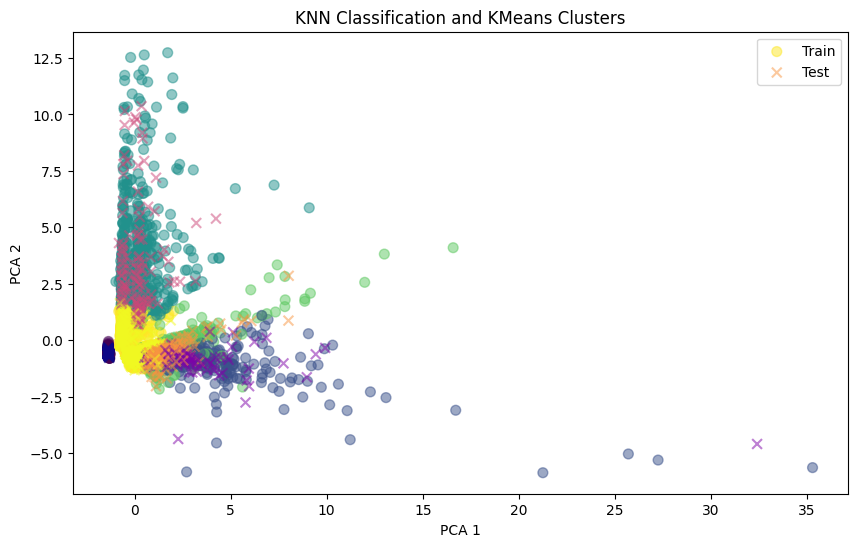

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_clusters, cmap='viridis', s=50, alpha=0.5, label='Train')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=knn_predictions, cmap='plasma', s=50, alpha=0.5, marker='x', label='Test')
plt.title('KNN Classification and KMeans Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [23]:
example_transaction_2 = {
    'step': 1,
    'type': 'PAYMENT',
    'amount': 500.00,
    'nameOrig': 'C100000003',
    'oldbalanceOrg': 1000.00,
    'newbalanceOrig': 500.00,
    'nameDest': 'C100000004',
    'oldbalanceDest': 1000.00,
    'newbalanceDest': 1500.00
}
classify_new_transaction(example_transaction_2, scaler, kmeans, knn, mlb.classes_)

Transaction appears to be non-fraudulent.
No anomalies detected.
